# Трансформеры и механизм внимания

В этом семинаре мы реализуем трансформер с механизмом внимания и попробуем решить простую задачу. Для этого мы реализуем
1) Scaled Dot Product Attention
2) Multi Head Attention
3) Positional encoding
4) Transformer Encoder & Decoder

![transformer](https://miro.medium.com/max/1156/1*j9MmpNZzbBqkWes0GN8IBQ.png "transformer")

Scaled Dot Product Attention

$\text{Attention}(Q, K, V) = \text{Softmax}(\frac{QK^T}{\sqrt{d_k}})V$

In [ ]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from typing import Callable

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_q)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_k)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        
        query = self.q(query)
        key = self.k(key) # [bs,T,dim_k]
        value = self.v(value)
        
        temp = query.bmm(key.transpose(1, 2)) # batch matrix-matrix product of matrices
        scale = query.size(-1) ** 0.5
        softmax = F.softmax(temp / scale, dim=-1)
        return softmax.bmm(value)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.heads = nn.ModuleList([
            Attention(dim_in, dim_q, dim_k) for _ in range(num_heads)
        ])
        self.linear = nn.Linear(num_heads * dim_k, dim_in)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        #ВАШ КОД ЗДЕСЬ
        heads_outputs = [head(query, key, value) for head in self.heads]
        return self.linear(
            torch.cat(heads_outputs, dim=-1)
        )  


Attention оперируют входными матрицами и никак не могут учитывать порядок элементов в текущем виде. Что-бы "обьяснить" нейронной сети последовательную природу данных, нам нужен positional encoding функция. 

$PE(pos, 2i) = \sin(pos / 1000^{2i/d_{model}})$

$PE(pos, 2i+1) = \cos(pos / 1000^{2i/d_{model}})$

Использование синуса - вариант, который предлагается в оригинальной статье, однако простейший способ - просто вектор со значениями от 0 до 1 длины $l$ где $l$ - длинна последовательности. 

In [ ]:
def simplest_position_encoding(
    seq_len: int,
    dim_model: int,
    device: torch.device = torch.device("cpu"),
) -> Tensor:
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    pos = torch.ones((1, seq_len, dim_model), dtype=torch.float, device=device) * pos
    return pos / pos.max()

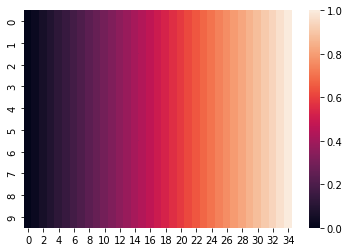

In [ ]:
sns.heatmap(simplest_position_encoding(35, 10).numpy()[0].T)

Одна из проблем, которая всплывает при таком кодировании, заключается в том, что вы не можете определить, сколько слов присутствует в определенном диапазоне.

In [ ]:
import math

def sinusoid_position_encoding(
    seq_len: int,
    dim_model: int,
    device: torch.device = torch.device("cpu"),
) -> Tensor:
    pos = torch.arange(seq_len, device=device).reshape(1, -1, 1)
    dim = torch.exp(torch.arange(0, dim_model, 2, device=device) * (-math.log(10000.0) / dim_model))
    pe = torch.zeros(1, seq_len, dim_model, device=device)
    pe[0, :, 0::2] = torch.sin(pos * dim)
    pe[0, :, 1::2] = torch.cos(pos * dim)
    return pe

Получаем d-мерный вектор, содержащий информацию о конкретной позиции слова в предложении. Такая кодировка не интегрирована в саму модель. Вместо этого  вектор используется для снабжения каждого слова информацией о его позиции в предложении. Другими словами, мы улучшаем входные данные модели, чтобы ввести порядок слов.

Интуиция:

Мы могли бы кодировать каждое порядковое число бинарной кодировкой.
Но использование двоичных значений было бы пустой тратой места в мире чисел с плавающей запятой. Поэтому вместо этого мы можем использовать их непрерывные аналоги с плавающей запятой — синусоидальные функции. Действительно, они эквивалентны чередующимся битам. 

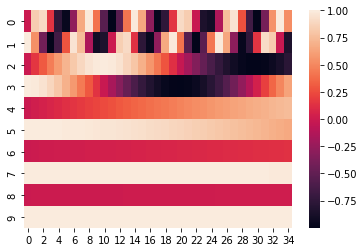

In [ ]:
sns.heatmap(sinusoid_position_encoding(35, 10).numpy()[0].T)

Начнем реализацию энкодера с residual болока. 

<!-- ![residual](residual_block.png) -->
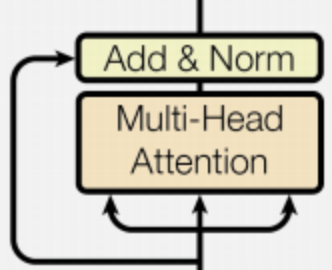

Тут, вместо MultiHead блока может быть что угодно, просто полносвязный слой например. 

In [ ]:
class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: Tensor) -> Tensor:
        #ВАШ КОД ЗДЕСЬ
        return self.norm(
            tensors[0] + self.dropout(self.sublayer(*tensors))
        )

Вот теперь мы готовы к написанию энкодера. 
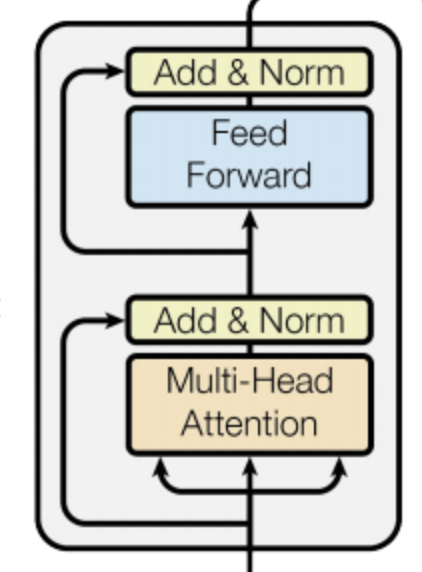
<!-- ![encoder](encoder.png) -->

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 1024,
        dropout: float = 0.1,
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
       
        self.attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        
        ff = nn.Sequential(
            nn.Linear(dim_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, dim_model),
        )
        self.feed_forward = Residual(
            ff,
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, src: Tensor) -> Tensor:
        src = self.attention(src, src, src)
        return self.feed_forward(src)
    

class TransformerEncoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 1024,
        dropout: float = 0.1,
        position_encoding: Callable = sinusoid_position_encoding
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )
        self.position_encoding = position_encoding

    def forward(self, src: Tensor) -> Tensor:
        seq_len, dimension = src.size(1), src.size(2)
        src += self.position_encoding(seq_len, dimension)
        
        for layer in self.layers:
            src = layer(src)

        return src

Декодер не сильно сложнее

<!-- ![decoder](decoder.png) -->
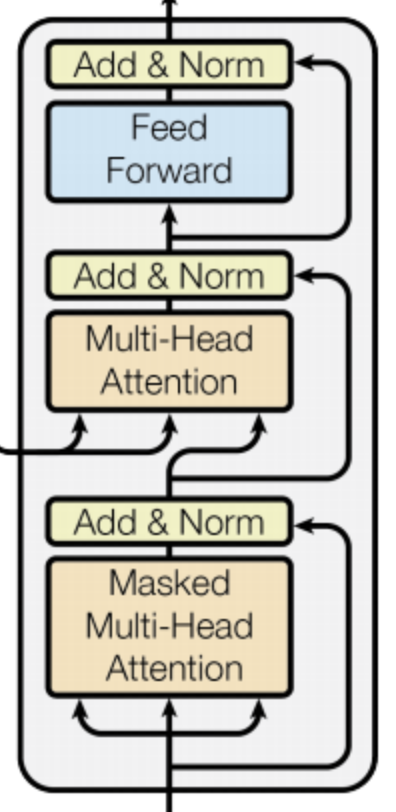


Декодер принимает target и память, у него 2 MultiHead attention слоя и второй слой принимает "память" из енкодера. 

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention_1 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.attention_2 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        
        ff = nn.Sequential(
            nn.Linear(dim_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, dim_model),
        )
        self.feed_forward = Residual(
            ff,
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, target: Tensor, memory: Tensor) -> Tensor:
        target = self.attention_1(target, target, target)
        target = self.attention_2(target, memory, memory)
        return self.feed_forward(target)


class TransformerDecoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        position_encoding: Callable = sinusoid_position_encoding
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )
        self.linear = nn.Linear(dim_model, dim_model)

        self.position_encoding = position_encoding

    def forward(self, target: Tensor, memory: Tensor) -> Tensor:
        seq_len, dimension = target.size(1), target.size(2)
        target += self.position_encoding(seq_len, dimension)
        
        for layer in self.layers:
            target = layer(target, memory)

        return torch.softmax(self.linear(target), dim=-1)

Простой тест

In [ ]:
batch_size = 8
seq_len = 32
dimensions = 100

src = torch.rand(batch_size, seq_len, dimensions)
target = torch.rand(batch_size, seq_len+3, dimensions)

encoder = TransformerEncoder(num_layers=2, dim_model=dimensions)
decoder = TransformerDecoder(num_layers=2, dim_model=dimensions)

encoder_output = encoder(src)

decoder_output = decoder(target, encoder_output)

print(encoder_output.shape, decoder_output.shape)

torch.Size([8, 32, 100]) torch.Size([8, 35, 100])


In [ ]:
print(src.shape, target.shape)

torch.Size([8, 32, 100]) torch.Size([8, 35, 100])


Теперь давайте обучим сеть на синтетическом примере. 
На реальном датасете, все будет так-же, но учить такую сеть нужно будет значительно дольше. 

In [ ]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)

    return data


def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))
    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

In [ ]:
len(train_data)

9000

In [ ]:
train_data[0]

[array([2., 0., 1., 0., 1., 0., 1., 0., 1., 3.]),
 array([2., 0., 1., 0., 1., 0., 1., 0., 1., 3.])]

In [ ]:
class Model(nn.Module):
    def __init__(self,):
        super().__init__()
        self.embedding = nn.Embedding(4, 8)
        self.encoder = TransformerEncoder(num_layers=2, dim_model=8)
        self.decoder = TransformerDecoder(num_layers=2, dim_model=8)
        
        self.output = nn.Linear(8, 4)
    
    def forward(self, src, target):
        src = self.embedding(src)
        target = self.embedding(target)
        
        encoder_output = self.encoder(src)
        decoder_output = self.decoder(target, encoder_output)
        return self.output(decoder_output)

In [ ]:
model = Model()

opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
model.train()
for epoch in range(10):
    total_loss = 0
    for batch in train_dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        output = model(X, y_input)

        loss = loss_fn(
            output.view(-1, 4), y_expected.flatten()
        )

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.detach().item()
    
    print(f"epoch {epoch}, train loss: {total_loss / len(train_dataloader)}")

epoch 0, train loss: 1.0905386058885431
epoch 1, train loss: 0.7787694880122392
epoch 2, train loss: 0.5274046387960902
epoch 3, train loss: 0.3981906910595945
epoch 4, train loss: 0.2917388851532308
epoch 5, train loss: 0.21453899784126315
epoch 6, train loss: 0.1458124297661077
epoch 7, train loss: 0.10975199085378562
epoch 8, train loss: 0.2637378482075136
epoch 9, train loss: 0.09074618648803956


In [ ]:
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in val_dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        output = model(X, y_input)

        loss = loss_fn(
            output.view(-1, 4), y_expected.flatten()
        )
        total_loss += loss.detach().item()
        
print(f'TEST LOSS {total_loss / len(val_dataloader)}')

TEST LOSS 2.109581508100989


# Часть 2

## Загрузка данных

Температура электрического трансформатора (ETT) является важным показателем в долгосрочном развертывании электроэнергии.

Этот набор данных состоит из данных за 2 года из двух отдельных округов Китая.
Чтобы изучить детализацию задачи прогнозирования временных рядов с длинными последовательностями, создаются различные подмножества: {ETTh1, ETTh2} для 1-часового уровня и ETTm1 для 15-минутного уровня. Каждая точка данных состоит из целевого значения «температура масла» и 6 характеристик силовой нагрузки. Train/val/test - 12/4/4 месяца.

In [ ]:
!git clone https://github.com/zhouhaoyi/ETDataset.git
!git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 25), reused 20 (delta 20), pack-reused 159
Receiving objects: 100% (187/187), 3.86 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Cloning into 'Informer2020'...
remote: Enumerating objects: 573, done.
remote: Total 573 (delta 0), reused 0 (delta 0), pack-reused 573
Receiving objects: 100% (573/573), 6.48 MiB | 15.29 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [ ]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
import pandas as pd
import os

data_root = './ETDataset/ETT-small/'
data = pd.read_csv(os.path.join(data_root, 'ETTh1.csv'))

In [ ]:
data.shape

(17420, 8)

In [ ]:
data.head(20)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
5,2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000
6,2016-07-01 06:00:00,7.167,2.947,2.132,0.782,5.026,1.858,22.792000
7,2016-07-01 07:00:00,7.435,3.282,2.310,1.031,5.087,2.224,23.143999
8,2016-07-01 08:00:00,5.559,3.014,2.452,1.173,2.955,1.432,21.667000
9,2016-07-01 09:00:00,4.555,2.545,1.919,0.817,2.680,1.371,17.445999


In [ ]:
data.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
std,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946
min,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000


In [ ]:
(data['OT'])

0        30.531000
1        27.787001
2        27.787001
3        25.044001
4        21.948000
           ...    
17415    10.904000
17416    11.044000
17417    10.271000
17418     9.778000
17419     9.567000
Name: OT, Length: 17420, dtype: float64

In [ ]:
N_f = 7 # число признаков (фичей)

### Создание датасета

In [ ]:
from data.data_loader import Dataset_ETT_hour 
from utils.tools import dotdict
from torch.utils.data import DataLoader

In [ ]:
args = dotdict()

args.root_path = data_root # корневой путь файла данных
args.data_path = 'ETTh1.csv' # файл данных
args.data = 'ETTh1' # данные

args.features = 'M' # задача прогнозирования, варианты: [M, S, MS]; M: многомерное прогнозирование многомерного, S: одномерное прогнозирование одномерного, MS: многомерное прогнозирование одномерного
args.target = 'OT' # целевая переменная в задаче S или MS
args.freq = 'h' # частота для кодирования характеристик времени, параметры: [s:секунды, t:минуты, h:ежечасно, d:ежедневно, b:рабочие дни, w:еженедельно, m:ежемесячно], вы также можете использовать более подробную частоту, например, 15 минут или 3 часа
args.checkpoints = './informer_checkpoints' # путь к чекпоинтам модели

args.seq_len = 96 # длина входной последовательности энкодера
args.label_len = 48 # стартовая длина токена декодера
args.pred_len = 24 # длина последовательности предсказания

args.padding = 0
args.batch_size = 32 
args.learning_rate = 0.0001

dataset_ett_train = Dataset_ETT_hour(
                    root_path=args.root_path,
                    data_path=args.data_path,
                    flag='train',
                    size=[args.seq_len, args.label_len, args.pred_len],
                    features=args.features,
                    target=args.target,
                    inverse=False,
                    timeenc=0,
                    freq=args.freq)

dataset_ett_val = Dataset_ETT_hour(
                    root_path=args.root_path,
                    data_path=args.data_path,
                    flag='val',
                    size=[args.seq_len, args.label_len, args.pred_len],
                    features=args.features,
                    target=args.target,
                    inverse=False,
                    timeenc=0,
                    freq=args.freq)

dataset_ett_test = Dataset_ETT_hour(
                    root_path=args.root_path,
                    data_path=args.data_path,
                    flag='test',
                    size=[args.seq_len, args.label_len, args.pred_len],
                    features=args.features,
                    target=args.target,
                    inverse=False,
                    timeenc=0,
                    freq=args.freq)

In [ ]:
train_loader = DataLoader(
                dataset_ett_train,
                batch_size=args.batch_size,
                shuffle=True,
                num_workers=0,
                drop_last=True)

val_loader = DataLoader(
                dataset_ett_val,
                batch_size=args.batch_size,
                shuffle=False,
                num_workers=1,
                drop_last=True)

test_loader = DataLoader(
                dataset_ett_test,
                batch_size=args.batch_size,
                shuffle=False,
                num_workers=1,
                drop_last=True)

In [ ]:
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
    break

In [ ]:
batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape

(torch.Size([32, 96, 7]),
 torch.Size([32, 72, 7]),
 torch.Size([32, 96, 4]),
 torch.Size([32, 72, 4]))

In [ ]:
args.enc_in = 7 
args.dec_in = 7
args.c_out = 7 
args.factor = 5 # вероятностный фактор внимания
args.d_model = 512 
args.n_heads = 8
args.e_layers = 2 
args.d_layers = 1 
args.d_ff = 2048 
args.dropout = 0.05 
args.attn = 'prob' # внимание, используемое в кодировщике, параметры: [prob, full]
args.embed = 'timeF' # кодирование характеристик времени, опции:[timeF, fixed, Learn]
args.activation = 'gelu' 
args.distil = True # использовать ли дистилляцию в энкодере
args.output_attention = False # выводить ли внимание в энкодере
args.mix = True
args.detail_freq = args.freq

args.batch_size = 100 
args.learning_rate = 0.001

device='cpu'

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_size, output_size, d_model, n_heads, e_layers, d_layers, d_ff, dropout):
        super().__init__()

        self.embedding = nn.Linear(input_size, d_model)
        self.encoder = TransformerEncoder(dim_model=d_model, 
                                          num_heads=n_heads,
                                          num_layers=e_layers, 
                                          dim_feedforward=d_ff,
                                          dropout=dropout)
        
        self.decoder = TransformerDecoder(dim_model=d_model, 
                                          num_heads=n_heads,
                                          num_layers=d_layers, 
                                          dim_feedforward=d_ff,
                                          dropout=dropout)
        
        self.output = nn.Linear(d_model, input_size)
    
    def forward(self, src, target, n_pred=24):
        
        src = self.embedding(src)
        target = self.embedding(target)

        encoder_output = self.encoder(src)
        decoder_output = self.decoder(target, encoder_output)
        
        return self.output(decoder_output)

In [ ]:
transformer = Transformer(input_size=7,
                          output_size=7,
                          d_model=args.d_model,
                          n_heads=args.n_heads,
                          e_layers=args.e_layers,
                          d_layers=args.d_layers,
                          d_ff=args.d_ff,
                          dropout=args.dropout)

transformer_optim = torch.optim.Adam(transformer.parameters(), lr=0.001)

In [ ]:
X = torch.randn(32,100,N_f)
Y = torch.randn(32,10,N_f)

Y_pred = transformer(X,Y)
Y_pred.shape
criterion = nn.MSELoss()

In [ ]:
Y_pred.shape

torch.Size([32, 10, 7])

In [ ]:
args.pred_len = 24

In [ ]:
from tqdm import tqdm
train_loss_epoch = []
val_loss_epoch = []
with torch.autograd.set_detect_anomaly(True):
    for epoch in tqdm(range(10)):
        train_loss = []
        
        #########
        # TRAIN #
        #########
        transformer.train(True)
        for i, (batch_x, batch_y, _, _) in tqdm(enumerate(train_loader)):

            true = batch_y[:,-args.pred_len:,:].type(torch.float).to(device)
            target = batch_y[:,-args.pred_len-1:-1,:].type(torch.float).to(device)

            pred = transformer(batch_x.type(torch.float).to(device),
                               target)
                
            loss = criterion(pred, true)
            train_loss.append(loss.item())

            transformer_optim.zero_grad()
            loss.backward()
            transformer_optim.step()

        train_loss_epoch.append(np.mean(train_loss))

        #######
        # VAL #
        #######
        transformer.train(False)
        val_loss = []
        with torch.autograd.no_grad():
          for i, (batch_x, batch_y, _, _) in enumerate(val_loader):
              true = batch_y[:,-args.pred_len:,:].type(torch.float).to(device)
              target = batch_y[:,-args.pred_len-1:-1,:].type(torch.float).to(device)
              pred = transformer(batch_x.type(torch.float).to(device),
                                target)
              loss = criterion(pred, true)
              val_loss.append(loss.item())

        val_loss_epoch.append(np.mean(val_loss))

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:04,  4.51s/it]
2it [00:08,  4.44s/it]
3it [00:13,  4.37s/it]
4it [00:17,  4.32s/it]
5it [00:21,  4.29s/it]
6it [00:25,  4.26s/it]
7it [00:30,  4.26s/it]
8it [00:34,  4.24s/it]
9it [00:38,  4.25s/it]
10it [00:42,  4.25s/it]
11it [00:47,  4.24s/it]
12it [00:51,  4.23s/it]
13it [00:55,  4.24s/it]
14it [00:59,  4.23s/it]
15it [01:03,  4.23s/it]
16it [01:08,  4.22s/it]
17it [01:12,  4.21s/it]
18it [01:16,  4.22s/it]
19it [01:20,  4.21s/it]
20it [01:25,  4.22s/it]
21it [01:29,  4.22s/it]
22it [01:33,  4.22s/it]
23it [01:37,  4.23s/it]
24it [01:41,  4.22s/it]
25it [01:46,  4.22s/it]
26it [01:50,  4.22s/it]
27it [01:54,  4.23s/it]
28it [01:58,  4.23s/it]
29it [02:03,  4.22s/it]
30it [02:07,  4.21s/it]
31it [02:11,  4.21s/it]
32it [02:15,  4.21s/it]
33it [02:19,  4.21s/it]
34it [02:24,  4.20s/it]
35it [02:28,  4.21s/it]
36it [02:32,  4.21s/it]
37it [02:36,  4.21s/it]
38it [02:40,  4.21s/it]
39it [02:45,  4.21s/it]
40it [02:49,  4

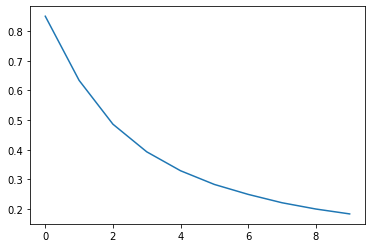

In [ ]:
plt.plot(train_loss_epoch)

In [ ]:
for i, (batch_x, batch_y, _, _) in enumerate(test_loader):
    with torch.autograd.no_grad():

        true = batch_y[:,-args.pred_len:,:].type(torch.float).to(device)
        
        target = batch_y[:,-args.pred_len-1:-1,:].type(torch.float).to(device)
        
        pred = transformer(batch_x.type(torch.float).to(device),
                          target)
        
        break

pred = pred.detach().cpu().numpy()
true = true.detach().cpu().numpy()

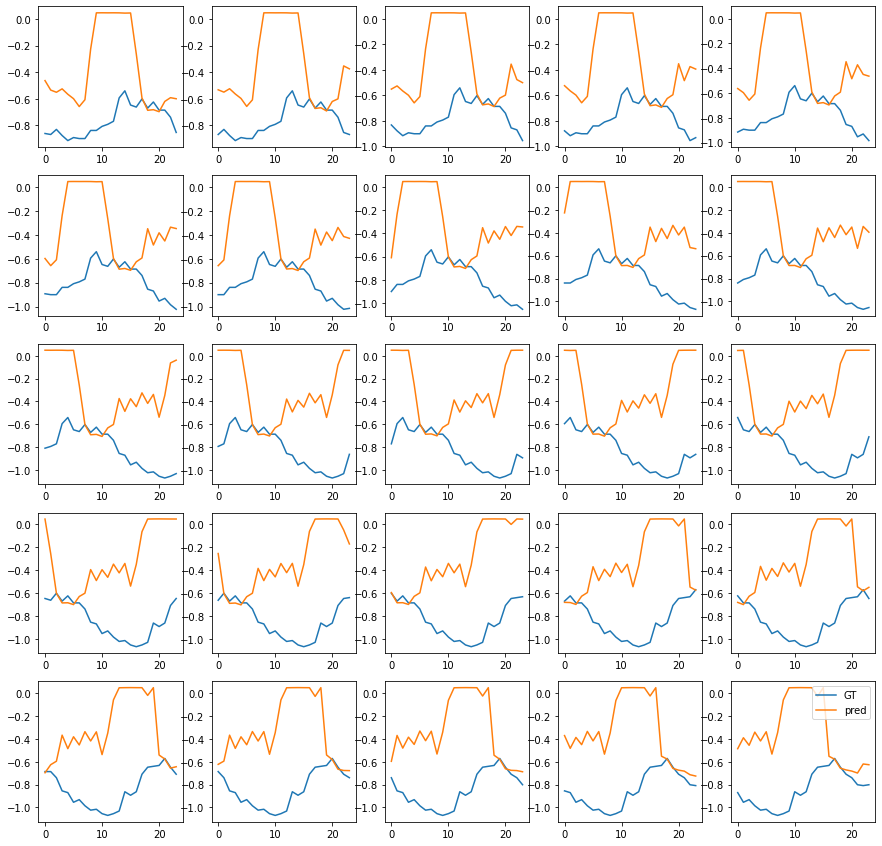

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(15,15))

for i,ax in enumerate(axes.flatten()):
    ax.plot(true[i,:,-1], label='GT')
    ax.plot(pred[i,:,-1], label='pred')
plt.legend()
plt.show()